# Setting up depedencies

This notebook details the results of the experiments that ran on parasilo.
Additionaly, it creates the plots 

In [5]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
import sys 
import os
import math
import datetime
import os
import json
import re
import pprint
import pandas as pd
from subprocess import *
import subprocess
import numpy as np
from importlib import reload  # Python 3.4+ only.
from IPython.display import Image

cwd = os.getcwd()
print(cwd)
# Adapt this path, it needs to point on the folder containing experiments/exptools.py.
sys.path.insert(1, os.path.abspath("src"))
import analysis
reload(analysis)

/home/adfaure/Projects/ptask-eval/analysis


<module 'analysis' from '/home/adfaure/Projects/ptask-eval/analysis/src/analysis.py'>

In [7]:
%%R -w 18 -h 8 --units in
library(tidyverse)
library(viridis)

theme_set(theme_minimal(base_size = 18))

load_instance_parasilo = function(path, noise) {
    instance = path
    data = read_table2(paste0(instance, "parasilo-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "Router (eno1)", timestamp = timestamp - min(timestamp)) %>% 
    bind_rows( read_table2(paste0(instance, "parasilo-1.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "Router (eno2)", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "parasilo-10.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "Tcpkali", timestamp = timestamp - min(timestamp)) ) %>% 
    bind_rows( read_table2(paste0(instance, "parasilo-11.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "MPI (only one host)", timestamp = timestamp - min(timestamp)) ) %>%
    mutate(noise = noise)
}

/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

  warnings.warn(x, RRuntimeWarning)
/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0

  warnings.warn(x, RRuntimeWarning)
/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

  warnings.warn(x, RRuntimeWarning)
/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packa

# Preparing the data

These functions loop thgough each configurations, extract the data and create the csv necessary for ploting the progress `mpi_progress.csv`.

In [8]:
# Load all and untar
instances_1subdiv_bcast = [ 
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/1s_no_kali_bcast/256c_no_kali_bcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/1s_no_periods_bcast/256c_noper_bcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/1s_periods10s_bcast/256c_per10s_bcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/1s_periods10sidle20sinter_bcast/256c_per10sidle20sinter_bcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/1s_periods20sidle10sinter_bcast/256c_per20sidle10sinter_bcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/1s_periods30s_bcast/256c_periods30s_bcast/")
]

instances_1subdiv_ibcast = [ 
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/1s_no_kali_ibcast/256c_no_kali_ibcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/1s_no_periods_ibcast/256c_noper_ibcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/1s_periods10s_ibcast/256c_per10s_ibcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/1s_periods10sidle20sinter_ibcast/256c_per10sidle20sinter_ibcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/1s_periods20sidle10sinter_ibcast/256c_per20sidle10sinter_ibcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/1s_periods30s_ibcast/256c_periods30s_ibcast/")
]

instances_50subdiv_bcast = [ 
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/50s_no_kali_bcast/256c_no_kali_bcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/50s_no_periods_bcast/256c_noper_bcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/50s_periods10s_bcast/256c_per10s_bcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/50s_periods10sidle20sinter_bcast/256c_per10sidle20sinter_bcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/50s_periods20sidle10sinter_bcast/256c_per20sidle10sinter_bcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/50s_periods30s_bcast/256c_periods30s_bcast/")
]

instances_50subdiv_ibcast = [ 
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/50s_no_kali_ibcast/256c_no_kali_ibcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/50s_no_periods_ibcast/256c_noper_ibcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/50s_periods10s_ibcast/256c_per10s_ibcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/50s_periods10sidle20sinter_ibcast/256c_per10sidle20sinter_ibcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/50s_periods20sidle10sinter_ibcast/256c_per20sidle10sinter_ibcast/"),
    analysis.Instances("../experiments/g5k/data/parasilo/parasilo/50s_periods30s_ibcast/256c_periods30s_ibcast/")
]

# Then we create a csv grouping all the running times, with the differents configurations.

runtimes = dict()

data = []
for instances_group in instances_1subdiv_bcast:
    for id_ in instances_group.instances:
        data.append(("1_subdivision", "Bcast", instances_group.name.replace("_bcast", "").replace("256c_", ""), instances_group.instances[id_].get_runtime2()))

for instances_group in instances_50subdiv_bcast:
    for id_ in instances_group.instances:
        data.append(("50_subdivision", "Bcast", instances_group.name.replace("_bcast", "").replace("256c_", ""), instances_group.instances[id_].get_runtime2()))
        
for instances_group in  instances_1subdiv_ibcast:
    for id_ in instances_group.instances:
        data.append(("1_subdivision", "IBcast", instances_group.name.replace("_ibcast", "").replace("256c_", ""), instances_group.instances[id_].get_runtime2()))

for instances_group in instances_50subdiv_ibcast :
    for id_ in instances_group.instances:
        data.append(("50_subdivision", "IBcast", instances_group.name.replace("_ibcast", "").replace("256c_", ""), instances_group.instances[id_].get_runtime2()))
    
df = pd.DataFrame(data=data, columns=[ 'nb_sub', 'bcast', 'interference', 'runtime'])

df.to_csv("../experiments/g5k/data/parasilo/parasilo/parasilo_all_intsance.csv")


FileNotFoundError: [Errno 2] No such file or directory: '../experiments/g5k/data/parasilo/parasilo/parasilo_all_intsance.csv'

# Vizualisations

## Plotting the running times

## Progress details of the parallel DGEMM application with different interferences patterns

In [10]:
%%R -w 12 -h 7 --units in

library(tidyverse)
library(ggplot2)
library(viridis)

ilevels = c("No interference",
            "10s interference / 20s idle", 
            "10s interference / 10s idle",  
            "30s interference / 30s idle",
            "20s interference / 10s idle", 
            "Constant interference")

theme_set(theme_minimal(base_size = 18))

data = read_csv("../experiments/g5k/data_dirty/parasilo/parasilo/parasilo_all_intsance.csv") %>% 
    mutate(interference = str_replace(interference, "no_kali", "No interference")) %>%
    mutate(interference = str_replace(interference, "noper", "Constant interference")) %>%
    mutate(interference = str_replace(interference, "per10sidle20sinter", "20s interference / 10s idle")) %>%
    mutate(interference = str_replace(interference, "per20sidle10sinter", "10s interference / 20s idle")) %>%
    mutate(interference = str_replace(interference, "per10s", "10s interference / 10s idle")) %>%
    mutate(interference = str_replace(interference, "periods30s", "30s interference / 30s idle")) %>%
    mutate(nb_sub = str_replace(nb_sub, "1_subdivision", "No subdivision"), 
           nb_sub = str_replace(nb_sub, "50_subdivision", "50 subdivisions")) %>%
    mutate(nb_sub = factor(nb_sub, levels = c("No subdivision", "50 subdivisions"))) %>% 
    mutate(bcast = str_replace(bcast, "IBcast", "Immediate broadcast"),
           bcast = str_replace(bcast, "Bcast", "Blocking broadcast"))

stats <- data %>% group_by(interference, nb_sub, bcast) %>% 
    summarise( sd_time = sd(runtime), mean_runtime = mean(runtime), n = n())

print(stats)

stats %>% ggplot(aes(y = mean_runtime, x = factor(interference, levels = ilevels), fill = bcast)) +
    geom_bar(stat = "identity", position = position_dodge())+  
    xlab("Interference pattern") + ylab("Application running time (s)") +
    facet_grid(~nb_sub) + 
    geom_errorbar(aes(ymin = mean_runtime - sd_time, ymax = mean_runtime + sd_time), 
                  position = position_dodge(0.9), width = 0.5) +
    scale_fill_viridis_d(end = 0.6) + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
    theme_bw(base_size = ) +
    theme(legend.position = "bottom")

# data %>% group_by(interference, nb_sub) %>% summarize(mean_rt= mean(runtime))


Error: '../experiments/g5k/data_dirty/parasilo/parasilo/parasilo_all_intsance.csv' does not exist in current working directory ('/home/adfaure/Projects/ptask-eval/analysis').


/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Error: '../experiments/g5k/data_dirty/parasilo/parasilo/parasilo_all_intsance.csv' does not exist in current working directory ('/home/adfaure/Projects/ptask-eval/analysis').

  warnings.warn(x, RRuntimeWarning)


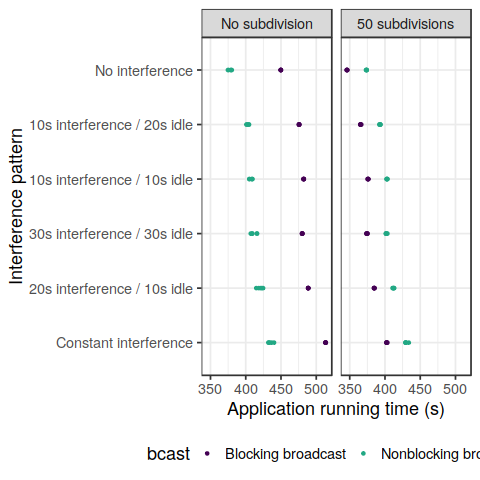

In [11]:
%%R 

data %>% ggplot(aes(y = runtime, x = factor(interference, levels = rev(ilevels)), color = bcast)) +
    geom_point(stat = "identity", position = position_dodge())+  
    xlab("Interference pattern") + ylab("Application running time (s)") +
    facet_grid(~nb_sub) + 
    scale_color_viridis_d(end = 0.6) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
        theme_bw(base_size = 18) +
    theme(legend.position = "bottom") + 
    coord_flip()
    # ggsave("~/Projects/Thesis/img/pdgemm_real_runtimes.pdf", width = 10, height = 4)

## 1 Subdivision with Bcast

/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Saving 12 x 8 in image

  warnings.warn(x, RRuntimeWarning)


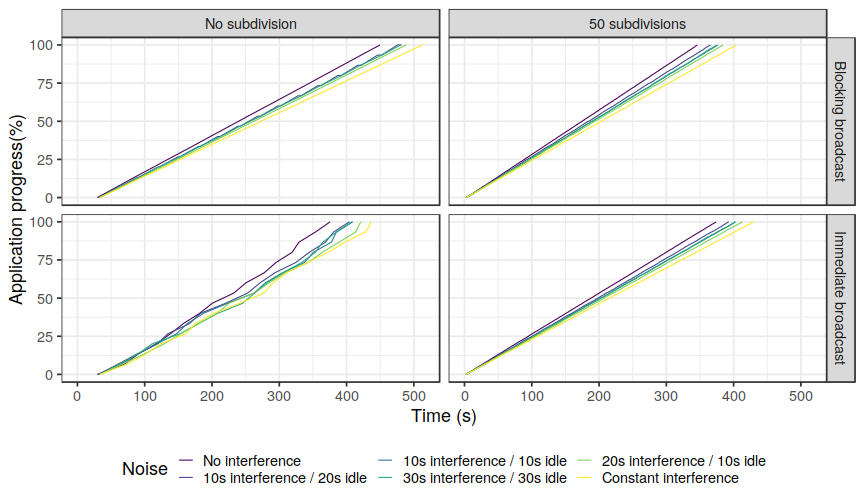

In [20]:
%%R -w 12 -h 7 --units in


ilevels = c("No interference",
            "10s interference / 20s idle", 
            "10s interference / 10s idle",  
            "30s interference / 30s idle",
            "20s interference / 10s idle", 
            "Constant interference")


s1bcast =  read_csv("../experiments/g5k/data/parasilo/parasilo_march/1s_no_kali_bcast/256c_no_kali_bcast/39a8ff15/mpi_progress.csv") %>%
                  mutate(noise = "No interference") %>% 
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/1s_no_periods_bcast/256c_noper_bcast/0d5ed150/mpi_progress.csv") %>%
                  mutate(noise = "Constant interference") ) %>% 
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/1s_periods10s_bcast/256c_per10s_bcast/0a88e697/mpi_progress.csv") %>%
                  mutate(noise = "10s interference / 20s idle") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/1s_periods30s_bcast/256c_periods30s_bcast/12f4aaa7/mpi_progress.csv") %>%
                  mutate(noise = "30s interference / 30s idle") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/1s_periods10sidle20sinter_bcast/256c_per10sidle20sinter_bcast/5049d8ea/mpi_progress.csv") %>%
                  mutate(noise = "20s interference / 10s idle") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/1s_periods20sidle10sinter_bcast/256c_per20sidle10sinter_bcast/3e5d9424/mpi_progress.csv") %>%
                  mutate(noise = "10s interference / 20s idle") ) %>% 
        mutate(src = "No subdivision", bcast =  "Blocking broadcast")  %>% mutate(progress = loop/max(loop)*100)
        
s1ibcast =  read_csv("../experiments/g5k/data/parasilo/parasilo_march/1s_no_kali_ibcast/256c_no_kali_ibcast/1c75e585/mpi_progress.csv") %>%
                  mutate(noise = "No interference") %>% 
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/1s_no_periods_ibcast/256c_noper_ibcast/b36254d7/mpi_progress.csv") %>%
                  mutate(noise = "Constant interference") ) %>% 
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/1s_periods10s_ibcast/256c_per10s_ibcast/189f2833/mpi_progress.csv") %>%
                  mutate(noise = "10s interference / 10s idle") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/1s_periods30s_ibcast/256c_periods30s_ibcast/0d1f97bc/mpi_progress.csv") %>%
                  mutate(noise = "30s interference / 30s idle") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/1s_periods10sidle20sinter_ibcast/256c_per10sidle20sinter_ibcast/03687fb6/mpi_progress.csv") %>%
                  mutate(noise = "20s interference / 10s idle") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/1s_periods20sidle10sinter_ibcast/256c_per20sidle10sinter_ibcast/30626684/mpi_progress.csv") %>%
                  mutate(noise = "10s interference / 20s idle") ) %>% 
        mutate(src = "No subdivision", bcast = "Immediate broadcast")  %>% mutate(progress = loop/max(loop)*100)
      
s50bcast = read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_no_kali_bcast/256c_no_kali_bcast/023bd52f/mpi_progress.csv") %>%
                  mutate(noise = "No interference") %>% 
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_no_periods_bcast/256c_noper_bcast/1af88686/mpi_progress.csv") %>%
                  mutate(noise = "Constant interference") ) %>% 
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_periods10s_bcast/256c_per10s_bcast/4f5cd068/mpi_progress.csv") %>%
                  mutate(noise = "10s interference / 10s idle") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_periods30s_bcast/256c_periods30s_bcast/6dcb0830/mpi_progress.csv") %>%
                  mutate(noise = "30s interference / 30s idle") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_periods10sidle20sinter_bcast/256c_per10sidle20sinter_bcast/49208eab/mpi_progress.csv") %>%
                  mutate(noise = "20s interference / 10s idle") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_periods20sidle10sinter_bcast/256c_per20sidle10sinter_bcast/07a7e1af/mpi_progress.csv") %>%
                  mutate(noise = "10s interference / 20s idle") ) %>% 
        mutate(src = "50 subdivisions", bcast = "Blocking broadcast")  %>% mutate(progress = loop/max(loop)*100)
      

s50ibcast =  read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_no_kali_ibcast/256c_no_kali_ibcast/2165277e/mpi_progress.csv") %>%
                  mutate(noise = "No interference") %>% 
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_no_periods_ibcast/256c_noper_ibcast/62c5c9c1/mpi_progress.csv") %>%
                  mutate(noise = "Constant interference") ) %>% 
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_periods10s_ibcast/256c_per10s_ibcast/daa39f98/mpi_progress.csv") %>%
                  mutate(noise = "10s interference / 10s idle") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_periods30s_ibcast/256c_periods30s_ibcast/7c9c89d2/mpi_progress.csv") %>%
                  mutate(noise = "30s interference / 30s idle") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_periods10sidle20sinter_ibcast/256c_per10sidle20sinter_ibcast/1ffcca2a/mpi_progress.csv") %>%
                  mutate(noise = "20s interference / 10s idle") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_periods20sidle10sinter_ibcast/256c_per20sidle10sinter_ibcast/19d1b5aa/mpi_progress.csv") %>%
                  mutate(noise = "10s interference / 20s idle") ) %>% 
        mutate(src = "50 subdivisions", bcast = "Immediate broadcast")  %>% mutate(progress = loop/max(loop)*100)
        
test = bind_rows(s1bcast, list(s1ibcast, s50bcast, s50ibcast)) %>% 
    mutate(nb_sub = factor(src, levels = c("No subdivision", "50 subdivisions"))) %>%
    rename("Noise" = "noise") %>%
    mutate(Noise = factor(Noise, levels = ilevels))     
                                                                                          
test %>% ggplot(aes(x = max_comp_end, y = progress)) +
    geom_line(aes(color = Noise)) + facet_grid(bcast~nb_sub) + 
    ylab("Application progress(%)") + xlab("Time (s)") +
    scale_colour_viridis_d() + 
    theme_bw(base_size = 18) +
    theme(legend.position = "bottom") +
    ggsave("img/pdgemm_real_progress.pdf", height = 8)

# Node activity details

## 50 sub divisions / broadcast

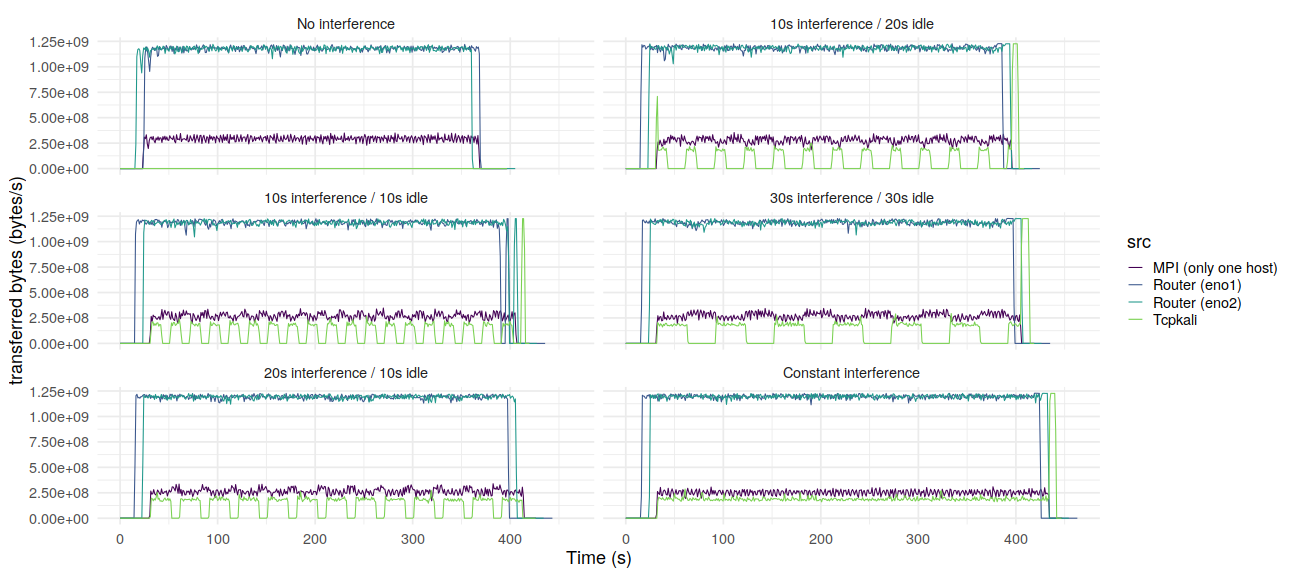

In [18]:
%%R -w 18 -h 8 --units in

ilevels = c("No interference",
            "10s interference / 20s idle", 
            "10s interference / 10s idle",  
            "30s interference / 30s idle",
            "20s interference / 10s idle", 
            "Constant interference")

full_inter   = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo_march/50s_no_kali_bcast/256c_no_kali_bcast/023bd52f/", "No interference")
no_inter     = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo_march/50s_no_periods_bcast/256c_noper_bcast/1af88686/", "Constant interference")  
ten_inter    = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo_march/50s_periods10s_bcast/256c_per10s_bcast/4f5cd068/", "10s interference / 10s idle")
thirty_inter = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo_march/50s_periods30s_bcast/256c_periods30s_bcast/6dcb0830/", "30s interference / 30s idle")
idle20if10   = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo_march/50s_periods20sidle10sinter_bcast/256c_per20sidle10sinter_bcast/07a7e1af/","10s interference / 20s idle")
idle10if20   = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo_march/50s_periods10sidle20sinter_bcast/256c_per10sidle20sinter_bcast/49208eab/", "20s interference / 10s idle")

bind_rows(full_inter, list(no_inter, ten_inter, thirty_inter, idle20if10, idle10if20)) %>%
    mutate(noise = factor(noise, levels = ilevels)) %>%
    ggplot(aes(x = timestamp, y = txb)) + 
        ylab("transferred bytes (bytes/s)") + xlab("Time (s)") +
        geom_line(aes(color = src)) + facet_wrap(~noise, ncol = 2) +
        theme_minimal(base_size = 18) +
        scale_colour_viridis_d(end = 0.8) +
        ggsave("img/50sdiv_bcast.pdf") 

## 50 subdivisions with Ibcast

In [ ]:
%%R -w 18 -h 8 --units in

no_inter     = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/50s_no_kali_ibcast/256c_no_kali_ibcast/2165277e/", "No interference")
full_inter   = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/50s_no_periods_ibcast/256c_noper_ibcast/b574cbf9/", "Constant interference")
ten_inter    = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/50s_periods10s_ibcast/256c_per10s_ibcast/d6335545/", "10s interference / 10s idle")
thirty_inter = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/50s_periods30s_ibcast/256c_periods30s_ibcast/cd081fa0/", "30s interference / 30s idle")
idle20if10   = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/50s_periods20sidle10sinter_ibcast/256c_per20sidle10sinter_ibcast/19d1b5aa/", "10s interference / 20s idle")
idle10if20   = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/50s_periods10sidle20sinter_ibcast/256c_per10sidle20sinter_ibcast/1ffcca2a/", "20s interference / 10s idle")

bind_rows(full_inter, list(no_inter, ten_inter, thirty_inter, idle20if10, idle10if20)) %>%
    mutate(noise = factor(noise, levels = ilevels)) %>%
    ggplot(aes(x = timestamp, y = txb, colour = src)) + 
        ylab("transferred bytes (bytes/s)") + xlab("Time (s)") +
        geom_line() +
        facet_wrap(~noise, ncol = 2) +
        scale_colour_viridis_d(end = 1)
        # geom_smooth(method = "loess", span = 0.1) + 
        # ggsave("~/Projects/Thesis/img/50sdiv_ibcast.pdf")


In [ ]:
%%R -w 18 -h 8 --units in

bind_rows(full_inter, list(no_inter, ten_inter, thirty_inter, idle20if10, idle10if20)) %>%
    mutate(noise = factor(noise, levels = ilevels)) %>%
    ggplot(aes(x = timestamp, y = txb, colour = src)) + 
        ylab("transferred bytes (bytes/s)") + xlab("Time (s)") +
        geom_line() +
        facet_wrap(~noise, ncol = 2) +
        scale_colour_viridis_d(end = 1)
        # geom_smooth(method = "loess", span = 0.1) + 
        # ggsave("~/Projects/Thesis/img/50sdiv_ibcast.pdf") 

# 1 subdivisions with Ibcast

In [ ]:
%%R -w 18 -h 8 --units in

no_inter     = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/1s_no_kali_ibcast/256c_no_kali_ibcast/1c75e585/", "No interference")
full_inter   = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/1s_no_periods_ibcast/256c_noper_ibcast/90f51510/", "Constant interference")
ten_inter    = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/1s_periods10s_ibcast/256c_per10s_ibcast/189f2833/", "10s interference / 10s idle")
thirty_inter = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/1s_periods30s_ibcast/256c_periods30s_ibcast/0d1f97bc/", "30s interference / 30s idle")
idle20if10   = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/1s_periods20sidle10sinter_ibcast/256c_per20sidle10sinter_ibcast/30626684/", "10s interference / 20s idle")
idle10if20   = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/1s_periods10sidle20sinter_ibcast/256c_per10sidle20sinter_ibcast/03687fb6/", "20s interference / 10s idle")

bind_rows(full_inter, list(no_inter, ten_inter, thirty_inter, idle20if10, idle10if20)) %>%
    mutate(noise = factor(noise, levels = ilevels)) %>%
    ggplot(aes(x = timestamp, y = txb, color = src)) + 
        ylab("transferred bytes (bytes/s)") + xlab("Time (s)") +
        geom_line(aes(color = src)) +
        facet_wrap(~noise, ncol = 2) +
        # geom_smooth(method = "loess", span = 0.05) + 
        scale_colour_viridis_d(end = 1)
        # ggsave("~/Projects/Thesis/img/1sdiv_ibcast.pdf") 

# 1 subdivisions with Bcast

In [ ]:
%%R -w 18 -h 8 --units in

no_inter     = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/1s_no_kali_bcast/256c_no_kali_bcast/09f5bff1/", "No interference")
full_inter   = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/1s_no_periods_bcast/256c_noper_bcast/0d5ed150/", "Constant interference")
ten_inter    = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/1s_periods10s_bcast/256c_per10s_bcast/0a88e697/", "10s interference / 10s idle")           
thirty_inter = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/1s_periods30s_bcast/256c_periods30s_bcast/12f4aaa7/", "30s interference / 30s idle")
idle20if10   = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/1s_periods20sidle10sinter_bcast/256c_per20sidle10sinter_bcast/3e5d9424/", "10s interference / 20s idle")
idle10if20   = load_instance_parasilo("../experiments/g5k/data/parasilo/parasilo/1s_periods10sidle20sinter_bcast/256c_per10sidle20sinter_bcast/5049d8ea/", "20s interference / 10s idle")

bind_rows(full_inter, list(no_inter, ten_inter, thirty_inter, idle20if10, idle10if20)) %>%
    mutate(noise = factor(noise, levels = ilevels)) %>%
    # filter(src != "Router (eno1)") %>%
    ggplot(aes(x = timestamp, y = txb, color = src)) + 
        ylab("transferred bytes (bytes/s)") + xlab("Time (s)") +
        geom_line(aes(color = src)) +
        facet_wrap(~noise, ncol = 2) +
        # geom_smooth(method = "loess", span = 0.1) + 
        scale_colour_viridis_d(end = 1)
        # ggsave("~/Projects/Thesis/img/1sdiv_bcast.pdf")